
--- 1. Memuat Dataset ---
✅ DataBerita.csv dimuat (614 data) | label unik: ['fakta' 'hoaks']
✅ turnbackhoax.csv dimuat (3071 data) | label unik: ['hoaks']
✅ berita.csv dimuat (541 data) | label unik: ['fakta']
✅ DataDetik.csv dimuat (4945 data) | label unik: ['fakta']
📊 Distribusi label gabungan:
label
fakta    4113
hoaks    3092
Name: count, dtype: int64

--- 2. Pra-pemrosesan ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



📌 Contoh 1 data preprocessing:
📝 Sebelum : JEMBER, KOMPAS.com –Dinas Kesehatan (Dinkes) Kabupaten Jember, Jawa Timur, mengungkap hasil uji laboratorium terhadap makanan bergizi gratis (MBG) yang disajikan di SDN Sidomekar 05 Kecamatan Semboro, menyusul dugaan keracunan makanan yang menimpa 16 siswa pada 26 September 2025 lalu. Dari hasil inv ...
✅ Sesudah : jember kompas com dinas kesehatan dinkes kabupaten jember jawa timur mengungkap hasil uji laboratorium makanan bergizi gratis mbg disajikan sdn sidomekar kecamatan semboro menyusul dugaan keracunan makanan menimpa siswa september hasil investigasi uji lab indikasi keracunan kuat berasal konsumsi sel ...

--- 3. Ekstraksi Fitur (TF-IDF) ---
✅ TF-IDF selesai | Jumlah data: 7205 | Jumlah fitur: 1000

--- 4. Penyeimbangan Data (1500 Hoaks : 1500 Fakta) ---
✅ Balancing selesai.
📊 Distribusi label setelah balancing:
label_num
0    1500
1    1500
Name: count, dtype: int64

--- 5. Pembagian Dataset (2000 Train : 1000 Test) ---
✅ Data latih

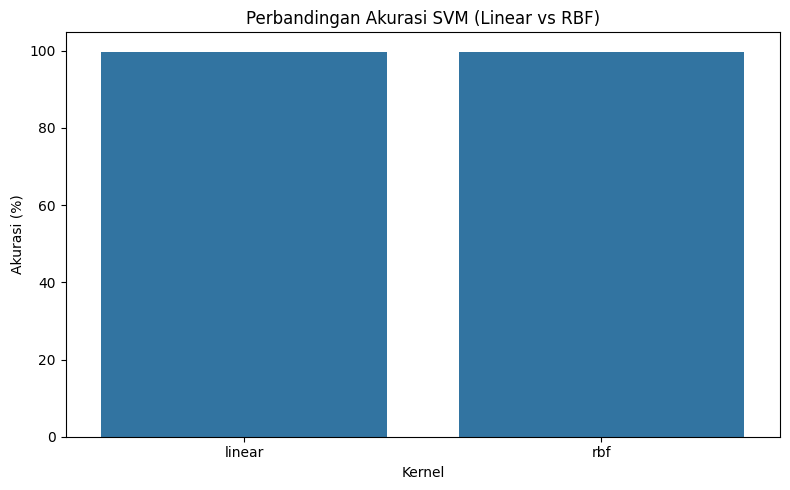

🖼️ Grafik akurasi disimpan sebagai: Grafik_Akurasi_SVM.png

--- 8. Pelatihan Ulang Model Terbaik ---
🔥 Model terbaik: Kernel=linear, C=1.0, Fitur=1000
✅ Model final siap digunakan untuk prediksi.


In [19]:
# ===============================================================
# DETEKSI HOAKS MENGGUNAKAN SUPPORT VECTOR MACHINE (SVM)
# ===============================================================
# Dilengkapi: Akurasi, Presisi, Recall, F1, Confusion Matrix, dan Visualisasi Hasil
# ===============================================================

import pandas as pd
import numpy as np
import re, random, requests
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ===============================================================
# 1. MEMUAT DATASET
# ===============================================================
print("\n--- 1. Memuat Dataset ---")

files = ['DataBerita.csv', 'turnbackhoax.csv', 'berita.csv', 'DataDetik.csv']
dataframes = []

# aturan label berdasarkan sumber file (sesuai tabel kamu)
LABEL_BY_FILE = {
    'turnbackhoax.csv': 'hoaks',
    'berita.csv': 'fakta',
    'DataDetik.csv': 'fakta',
    # DataBerita.csv = campuran -> harus pakai label yang ada di file
}

for file in files:
    try:
        df_temp = pd.read_csv(file)

        # normalisasi kolom teks
        if 'Content' in df_temp.columns:
            df_temp.rename(columns={'Content': 'teks_berita'}, inplace=True)
        elif 'Title' in df_temp.columns:
            df_temp.rename(columns={'Title': 'teks_berita'}, inplace=True)

        # pastikan kolom teks ada
        if 'teks_berita' not in df_temp.columns:
            raise ValueError(f"Kolom teks tidak ditemukan di {file} (butuh 'Content' / 'Title' / 'teks_berita').")

        # set label sesuai sumber file
        if file in LABEL_BY_FILE:
            df_temp['label'] = LABEL_BY_FILE[file]
        else:
            # khusus DataBerita.csv (campuran) -> wajib ada kolom label
            if 'label' not in df_temp.columns:
                raise ValueError(
                    f"{file} adalah dataset campuran, tapi kolom 'label' tidak ditemukan. "
                    f"Tambahkan label hoaks/fakta di file tersebut."
                )

        # rapikan label
        df_temp['label'] = df_temp['label'].astype(str).str.lower().str.strip()

        dataframes.append(df_temp[['teks_berita', 'label']])
        print(f"✅ {file} dimuat ({len(df_temp)} data) | label unik: {df_temp['label'].unique()[:5]}")

    except FileNotFoundError:
        print(f"⚠️ {file} tidak ditemukan.")

if not dataframes:
    raise FileNotFoundError("Tidak ada file CSV ditemukan!")

df = pd.concat(dataframes, ignore_index=True)
df = df.dropna(subset=['label', 'teks_berita']).drop_duplicates(subset='teks_berita').reset_index(drop=True)

# validasi label hanya hoaks/fakta
df = df[df['label'].isin(['hoaks', 'fakta'])].reset_index(drop=True)

print("📊 Distribusi label gabungan:")
print(df['label'].value_counts())

# ===============================================================
# 2. PRA-PROSES TEKS
# ===============================================================
print("\n--- 2. Pra-pemrosesan ---")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

# === Simpan contoh teks asli (1 data) sebelum preprocessing ===
contoh_asli = df['teks_berita'].iloc[0]

# === Jalankan preprocessing untuk semua data ===
df['text_cleaned'] = df['teks_berita'].apply(preprocess_text)

# === Tampilkan 1 contoh hasil preprocessing ===
contoh_bersih = df['text_cleaned'].iloc[0]
print("\n📌 Contoh 1 data preprocessing:")
print("📝 Sebelum :", contoh_asli[:300], "...")
print("✅ Sesudah :", contoh_bersih[:300], "...")

# ===============================================================
# 3. EKSTRAKSI FITUR (TF-IDF)
# ===============================================================
print("\n--- 3. Ekstraksi Fitur (TF-IDF) ---")

# Validasi & normalisasi label dulu (biar aman)
df['label'] = df['label'].astype(str).str.lower().str.strip()

# Ambil hanya data dengan label hoaks/fakta
df = df[df['label'].isin(['hoaks', 'fakta'])].reset_index(drop=True)

# Mapping label ke numerik: hoaks=1, fakta=0
y_all = df['label'].map({'hoaks': 1, 'fakta': 0}).astype(int).values

# TF-IDF (fit di seluruh data sesuai alur diagram kamu)
TFIDF_FEATURES = 1000
vectorizer = TfidfVectorizer(max_features=TFIDF_FEATURES)
X_all = vectorizer.fit_transform(df['text_cleaned']).toarray()

print(f"✅ TF-IDF selesai | Jumlah data: {X_all.shape[0]} | Jumlah fitur: {X_all.shape[1]}")


# ===============================================================
# 4. PENYEIMBANGAN DATA (1500 : 1500)
# ===============================================================
print("\n--- 4. Penyeimbangan Data (1500 Hoaks : 1500 Fakta) ---")

TARGET_PER_CLASS = 1500

# Buat DataFrame gabungan fitur + label untuk memudahkan sampling
df_feat = pd.DataFrame(X_all)
df_feat['label_num'] = y_all

# Pisahkan kelas
df_hoaks = df_feat[df_feat['label_num'] == 1]
df_fakta = df_feat[df_feat['label_num'] == 0]

# Validasi jumlah minimal data
if len(df_hoaks) < TARGET_PER_CLASS or len(df_fakta) < TARGET_PER_CLASS:
    raise ValueError(
        f"Data tidak cukup untuk balancing {TARGET_PER_CLASS}:{TARGET_PER_CLASS}. "
        f"Hoaks={len(df_hoaks)}, Fakta={len(df_fakta)}"
    )

# Ambil masing-masing 1500
df_hoaks_s = df_hoaks.sample(n=TARGET_PER_CLASS, random_state=42)
df_fakta_s = df_fakta.sample(n=TARGET_PER_CLASS, random_state=42)

# Gabungkan & shuffle
df_balanced = pd.concat([df_hoaks_s, df_fakta_s], ignore_index=True)\
               .sample(frac=1, random_state=42)\
               .reset_index(drop=True)

print("✅ Balancing selesai.")
print("📊 Distribusi label setelah balancing:")
print(df_balanced['label_num'].value_counts())


# ===============================================================
# 5. PEMBAGIAN DATASET (2000 TRAIN : 1000 TEST)
# ===============================================================
print("\n--- 5. Pembagian Dataset (2000 Train : 1000 Test) ---")

X = df_balanced.drop(columns=['label_num']).values
y = df_balanced['label_num'].values

# 1000 data untuk test, sisanya otomatis 2000 untuk train
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1000,
    random_state=42,
    stratify=y
)

print(f"✅ Data latih : {len(X_train)}")
print(f"✅ Data uji   : {len(X_test)}")

print("📊 Distribusi y_train:")
print(pd.Series(y_train).value_counts())

print("📊 Distribusi y_test:")
print(pd.Series(y_test).value_counts())


# ===============================================================
# 6. PEMODELAN DENGAN SVM (Eksperimen Kernel)
# ===============================================================
print("\n--- 6. Pemodelan dengan SVM ---")

configs = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'rbf',    'C': 1.0},
]

results = []

for cfg in configs:
    print(f"\n🧠 Training SVM | Kernel={cfg['kernel']} | C={cfg['C']}")

    model = SVC(kernel=cfg['kernel'], C=cfg['C'], random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1  = f1_score(y_test, y_pred, zero_division=0)

    print(f"Akurasi  : {acc*100:.2f}%")
    print(f"Presisi  : {pre*100:.2f}%")
    print(f"Recall   : {rec*100:.2f}%")
    print(f"F1-Score : {f1*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Fakta (0)', 'Hoaks (1)'],
        yticklabels=['Fakta (0)', 'Hoaks (1)']
    )
    plt.title(f"Confusion Matrix - SVM ({cfg['kernel']})")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.tight_layout()

    cm_file = f"Confusion_Matrix_SVM_{cfg['kernel']}.png"
    plt.savefig(cm_file, dpi=300)
    plt.close()
    print(f"🖼️ Confusion Matrix disimpan: {cm_file}")

    results.append({
        'Kernel': cfg['kernel'],
        'C': cfg['C'],
        'Fitur_TFIDF': TFIDF_FEATURES,
        'Akurasi': round(acc*100, 2),
        'Presisi': round(pre*100, 2),
        'Recall': round(rec*100, 2),
        'F1-Score': round(f1*100, 2)
    })


# ===============================================================
# 7. PENGUJIAN & EVALUASI MODEL (Ringkasan + Simpan)
# ===============================================================
print("\n--- 7. Pengujian dan Evaluasi Model ---")

results_df = pd.DataFrame(results)
print(results_df)

# Simpan hasil evaluasi
results_df.to_csv("Hasil_Evaluasi_SVM.csv", index=False)
print("\n📁 Hasil evaluasi disimpan di: Hasil_Evaluasi_SVM.csv")

# Simpan tabel markdown (buat BAB IV)
results_df.to_markdown("Tabel_Hasil_Evaluasi_SVM.md", index=False)
print("📁 Tabel markdown disimpan di: Tabel_Hasil_Evaluasi_SVM.md")

# Visualisasi perbandingan metrik
print("\n📈 Membuat grafik perbandingan metrik...")

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Kernel', y='Akurasi')
plt.title("Perbandingan Akurasi SVM (Linear vs RBF)")
plt.xlabel("Kernel")
plt.ylabel("Akurasi (%)")
plt.tight_layout()
plt.savefig("Grafik_Akurasi_SVM.png", dpi=300)
plt.show()

print("🖼️ Grafik akurasi disimpan sebagai: Grafik_Akurasi_SVM.png")


# ===============================================================
# 8. TRAIN ULANG MODEL TERBAIK (Opsional - untuk prediksi baru)
# ===============================================================
print("\n--- 8. Pelatihan Ulang Model Terbaik ---")

best_row = results_df.loc[results_df['Akurasi'].idxmax()]
best_kernel = best_row['Kernel']
best_C = float(best_row['C'])

print(f"🔥 Model terbaik: Kernel={best_kernel}, C={best_C}, Fitur={TFIDF_FEATURES}")

model_final = SVC(kernel=best_kernel, C=best_C, probability=True, random_state=42)
model_final.fit(X, y)

print("✅ Model final siap digunakan untuk prediksi.")

